# 6. Gyakorlat: Párbajozó dupla Q-tanulás
## Könyvtárak

In [15]:
import os
import gym
import random 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from collections import namedtuple

mpl.rc('animation', html='jshtml')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')

## Vizualizációs függvények

In [16]:

# Egy epizód lejátszása egy neurális hálózattal
def render_policy_net(agent, n_max_steps=100, seed=42, done_close=True, epsilon=0):
    env = gym.make('FrozenLake-v1')
    env.seed(seed)
    s = env.reset()
    frames = []
    rewards = []

    for step in range(n_max_steps):
        env.render()
        a = agent.act(s, epsilon)
        sp, r, done, info = env.step(a)
        rewards.append(r)
        s = sp
        if(done_close and done):
            break

    env.close()
    return rewards


# Jutalmak ábrázolása
def plot_rewards(rewards, episode = True):
    xlabel = 'Epizód' if episode else 'Lépés'
    df = pd.DataFrame({'Rewards': rewards, 'i': np.arange(len(rewards))})
    plt.figure(figsize = (6, 6))
    sns.lineplot(data=df, x = 'i', y = 'Rewards').set(title = f"Jutalom {len(rewards)} epizód alatt")
    plt.xlabel(xlabel)
    plt.ylabel('Jutalom')
    plt.show()

---
## $Q$-hálózat

In [17]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        
        self.fc_V = nn.Linear(64, 64) 
        self.out_V = nn.Linear(64, 1)  

        self.fc_A = nn.Linear(64, 64) 
        self.out_A = nn.Linear(64, action_size)  
        
    def forward(self, s):
        if s.dim() == 1 or s.size(1) != 64:
            s = F.one_hot(s.to(torch.int64), num_classes=64).float()
        
        x = F.relu(self.fc1(s))

        V = F.relu(self.fc_V(x))
        V = self.out_V(V)

        A = F.relu(self.fc_A(x))
        A = self.out_A(A)
        
        A_mean = A.mean(dim=1, keepdim=True)
        Q = V + A - A_mean 

        return Q, V

---
## Tapasztalat visszajátszás

In [18]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['s', 'a', 'r', 'sp', 'done'])
    
    def add(self, s, a, r, sp, done):
        e = self.experience(s, a, r, sp, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)  # Mintavétel egyenletes eloszlással

        states = torch.from_numpy(np.vstack([e.s for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.a for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.r for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.sp for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

---
## Ügynök

In [57]:
class Agent():
    def __init__(self, state_size, action_size, buffer_size, batch_size, update_every, gamma, alpha, tau):
        self.tau = tau
        self.gamma = gamma
        self.alpha = alpha
        self.t_step = 0
        self.batch_size = batch_size
        self.state_size = state_size
        self.buffer_size = buffer_size
        self.action_size = action_size
        self.update_every = update_every
        self.action_stack = np.zeros([0, 2])
        self.local_model_name = 'checkpoint_DDDQN_local.pth'
        self.target_model_name = 'checkpoint_DDDQN_target.pth'
        self.state_stack = []

        self.qnetwork_local = QNetwork(state_size, action_size)  # Lokális hálózat (minden lépésben)
        self.qnetwork_target = QNetwork(state_size, action_size)  # Célhálózat (minden upadte_every lépéshez)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = alpha)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def step(self, s, a, r, sp, done):
        self.memory.add(s, a, r, sp, done)  # Tapasztalat mentése a tapasztalat visszajátszási memóriába
        self.action_stack = np.vstack([self.action_stack, np.array([a, r])])
        self.t_step = (self.t_step + 1) % self.update_every  # Belső időlépés változó frissítése
        
        if self.t_step == 0 and len(self.memory) > self.batch_size:  # Ha van elég rekord a tapasztalat visszajátszásban mintavétel és tanulás
            experiences = self.memory.sample()  # Mintavétel a tapasztalat visszajátszásból
            self.learn(experiences)  # Ügynök tanítása

    def act(self, s, eps):  # Action choice based on state
        if isinstance(s, tuple):
            state = np.array(s[0]) if isinstance(s[0], int) else s[0]
        else:
            state = np.array([s]) if isinstance(s, int) else s

        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)


        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values_tuple = self.qnetwork_local(state)
            action_values = action_values_tuple[0]
            print(action_values)

        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences  # Tapasztalat kicsomagolása

        # Q-értékek kiszámítása
        target_action_value, _ = self.qnetwork_target(next_states)  # Cél Q-hálózat predikciója a következő állapotra
        q_targets_next = target_action_value.detach().max(1)[0].unsqueeze(1)  # Számítási gráfról lecsatlakoztatás és felesleges dimenzió eldobása
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)  # Q-értékek a következő állapotban
        local_action_value, _ = self.qnetwork_local(states)  # Lokális hálózat predikciója az aktuális állapotban a Q-értékekre
        q_expected = local_action_value.gather(1, actions)  # Q-értékek az aktuális állapotban
        
        # Költség számítása
        loss = F.mse_loss(q_expected, q_targets)  # Költség kiszámítása
        self.optimizer.zero_grad()  # Gradiensek törlése a számítási gráfról
        loss.backward()  # Hiba visszaáramoltatása a hálózatba
        self.optimizer.step()  # Lépés az optimalizálóval (paraméterek frissítése)

        self.soft_update(self.qnetwork_local, self.qnetwork_target)  # Célhálózat frissítése Polyak átlagolással

    def soft_update(self, local_model, target_model):  # Lágy frissítés Polyak átlagolással
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)  # Polyak átlagolás szerinti frissítés
    
    def save_model(self):
        torch.save(self.qnetwork_local.state_dict(), self.local_model_name)  # Lokális modell mentése
        torch.save(self.qnetwork_target.state_dict(), self.target_model_name)  # Cél modell mentése

---
## Tanítás

In [58]:
tau = 1e-3  # Polyak átlagolás paramétere
max_i = 3000  # Epizódok maximális száma
alpha = 5e-4  # Tanulási sebesség 
gamma = 0.99  # Diszkontálási faktor
max_t = 1000  # Egy epizódon belüli lépésszám
scores = []  # Jutalmak nyomon követése
eps_end = 0.01  # Felfedezési ráta végső értéke
eps_decay = 0.995  # Felfedezési ráta párologtatási együtthatója
eps_start = 1.0  # Felfedezési ráta kezdőértéke
batch_size = 64  # Kötegméret a tapasztalat visszajátszáshoz
buffer_size = int(1e5)  # Tapasztalat visszajátszás maximális mérete
update_every = 4  # Milyen gyakran frissüljön a célhálózat
scores_window = deque(maxlen = 100) # Keep track of the last 100 iterations
eps = eps_start  # Felfedezési ráta kezdőértékének megadása

env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode='rgb_array')
print('Környezet : ', env.observation_space.shape)
print('Cselekvések száma: ', env.action_space.n)

agent = Agent(state_size=env.observation_space.n, 
              action_size=env.action_space.n,
              buffer_size=buffer_size,
              batch_size=batch_size,
              update_every=update_every,
              gamma=gamma,
              alpha=alpha,
              tau=tau)


Környezet :  ()
Cselekvések száma:  4


In [59]:
for i in range(1, max_i + 1):  # Iteráció minden epizódra
    s = env.reset()
    r_sum = 0

    for t in range(max_t):  # Iteráció minden lépésre az epizódon belül
        a = agent.act(s, eps)  # Ügynök állapotra adott cselekvése
        try:
            sp, r, done, _, info = env.step(a)  # Következő állapot és jutalom megfigyelése
        except ValueError as e:
            print(f"Error: {e}")
            print(f"Returned values from env.step(): {env.step(a)}")
            break  # Break the loop to investigate the issue

        agent.step(s, a, r, sp, done)  # Ügynök frissítése
        r_sum += r
        s = sp
        
        if done:
            break


    scores_window.append(r_sum)  # Legutóbbi kumulált jutalom elmentése
    scores.append(r_sum)  # Legutóbbi kumulált jutalom hozzáfűzése az összes jutalomhoz
    eps = max(eps_end, eps_decay * eps)  # Epszilon párologtatása

    
    if i % 100 == 0:
        print(f'Epizód: {i}, Átlagos jutalom: {np.mean(scores_window)}')
        
    if np.mean(scores_window) >= 200.0: 
        print(f'Környezet megoldva {i} epizód alatt')
        print(f'Átlagos pontszám: {np.mean(scores_window)}')
        agent.save_model()
        print('Modellek mentése sikeres')  
        break

tensor([[-0.0629, -0.1150, -0.1532, -0.1531]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1477, -0.1477, -0.1477, -0.1477]]])
tensor([[[-0.1185, -0.1185, -0.1185, -0.1185]]])
tensor([[[-0.1185, -0.1185, -0.1185, -0.1185]]])
tensor([[[-0.1477, -0.1477, -0.1477, -0.1477]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1413, -0.1413, -0.1413, -0.1413]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1210, -0.1210, -0.1210, -0.1210]]])
tensor([[[-0.1413, -0.

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 9 has size 2

## Jutalmak ábrázolása

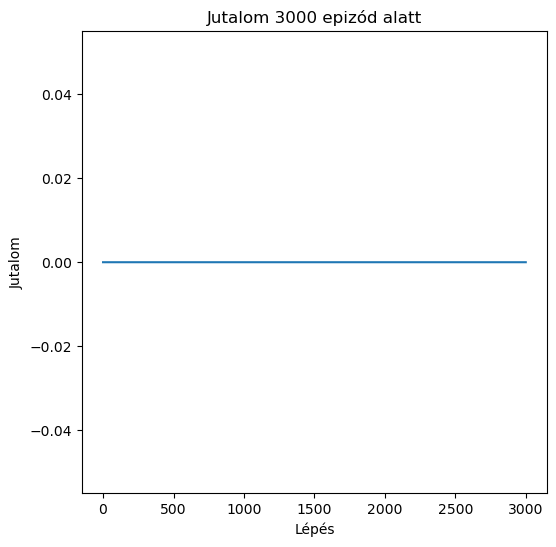

In [49]:
plot_rewards(scores, episode=False)

Duel dupla q-tanulás elméleti háttere:
- A dueling deep Q-network (Dueling DQN) egy másik változata a mély Q-hálózatoknak
- Ebben az architektúrában a hálózatot úgy tervezzük meg, hogy különbséget tegyen az állapotérték (state value) és az akcióelőnyök (advantage values) között.
- A dueling DQN hálózat két fő részből áll:
  - Állapotérték-függvény (V(s))
  - Előny-függvény (A(s, a))
- A párbajozó Q-tanulás algoritmusa explicit módon
kettéválasztja az állapot-érték és előny
függvények megbecslését minden állapot művelet
esetén.
- Q(s,a;θ,α,β) = V(s;θ,β) + (A(s,a;θ,α) - 1/|A|∑a'A(s,a';θ,α))